#Objective
<h3> Currently, we are facing the problem of shortcomings of predicting the close of next day with respect to the previous close values. However, in this notebook, our aim is to predict the close while taking into consideration the average sentiment of StockTwits and Close simultaneously.
</h3>


<h4> Keep in mind that we are using in this notebook our scraped dataset for sentiment analysis feature for each tweet</h4>

**Briefly, you can find in the notebook an implementing for**: 
1. Predicting the tomorrow's Close using LSTM.
2. A greedy trading algorithm which gives advice to the investor when they should buy or sell.

 

# Installing Important Packages

In [ ]:
#Installs
!pip install backtrader
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 410 kB 10.9 MB/s 
     |████████████████████████████████| 109 kB 8.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


# Importing the Data

In [ ]:
import math 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from keras.models import Sequential
from datetime import date, timedelta
from re import X

#BackTrader for Trading Algorithm

import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
import sys



In [ ]:
def daterange(start_date, end_date):
      for n in range(int((end_date - start_date).days)):
          yield start_date + timedelta(n)  
 

# Training Class
<h4> Class For PreProcessing the data and training the Model using LSTM </h4>

In [ ]:

class trainingTheModel(): 

    def __init__(self, path, stockName):
        self.path = path 
        self.df = pd.read_csv(path) 
        self.stockName = stockName

    # Concatanating the Sentiment scores for each day with the Close Price
    def concatenate(self, startDate, endDate):
        self.df.rename(columns = {"predicted_label" : "label"}, inplace = True)
        self.df = self.df[['Date','label', 'symbol']]
        # self.df['Date'] = pd.datetime(self.df['Date'])
        df = self.df
        StockName = self.stockName

        sentimentDF = df[df['symbol'] ==StockName]
        sentDF = df.groupby(['Date']).mean()


        stock_DF = pdr.get_data_yahoo(StockName,  start = startDate , end = endDate)
        df_temp = stock_DF['Close']
        # sentDF.drop(columns = ['user', 'message_id'] , inplace=True)
        
        sentDF = sentDF[sentDF.index>= startDate]
        sentDF = sentDF[sentDF.index <= endDate]
        
        #Getting Stock Information  
        
        df_temp = pd.DataFrame()
        df_temp['Close'] = stock_DF['Close']
        df = df_temp.copy()
        df['Date'] = df.index.values
        sentDF['Date'] = sentDF.index.values
        df.index.name = None
        sentDF.index.name = None
        sentDF['Date']= pd.to_datetime(sentDF['Date'])
        df_cd = pd.merge(df,sentDF, how='inner', on = 'Date')
        df = df_cd.set_index('Date')
        self.df = df 
        self.df_temp = df_temp
        # print("HERE", self.df.columns)

        return df, df_temp

    #Visualizing the Close Price History 
    def plotCloseVsDate(self):
        
        df,_ = self.concatenate("2012-01-03", '2019-12-31')

        plt.figure(figsize = (16,8))
        plt.title('CLose Price History')
        plt.plot(df['Close'])
        plt.xlabel('Date' , fontsize = 16)
        plt.ylabel('Close Price USD' , fontsize = 16)
        plt.show()

    #Splitting the data to train and test data 
    def splittingData(self):

        df,df_temp = self.df, self.df_temp
        data = df_temp
        dataset = data.values 
        self.training_data_len = math.ceil(len(dataset) * 0.8)
        self.scaler = MinMaxScaler(feature_range = (0,1))
        scaled_data = self.scaler.fit_transform(dataset)
        df['Close'] = scaled_data
        self.scaled_data = np.array(df)
        train_data = self.scaled_data[: self.training_data_len,] 

        # print(train_data.shape)
        self.x_train = []
        self.y_train = []

        for i in range(60, len(train_data)):
            self.x_train.append(train_data[i-60: i ,])
            self.y_train.append(train_data[i,0])
            # if(i <= 60): 
            #     print(self.x_train)
            #     print(self.y_train)
        self.x_train, self.y_train = np.array(self.x_train), np.array(self.y_train)
        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1], 2))

    # The model architecture using TensorFlow - 
    def modelArchitecture(self,epochs = 1 , batch_size = 1):
        self.model = Sequential()
        self.model.add(LSTM(50, return_sequences= True, input_shape = (self.x_train.shape[1],2)))
        self.model.add(LSTM(50,return_sequences = False))
        self.model.add(Dense(25))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss = 'mean_squared_error')
        self.model.fit(self.x_train,self.y_train,batch_size = batch_size, epochs = epochs)
    
    #Test the LSTM Model
    def testModel(self):
        df = np.array(self.df)
        test_data = df[self.training_data_len - 60 : ,]

        self.x_test = []
        dataset = self.df_temp.values
        self.y_test = dataset[self.training_data_len:]

        for i in range(60, len(test_data)):
            self.x_test.append(test_data[i-60:i])
        self.x_test = np.array(self.x_test)
        self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], self.x_test.shape[1],2))

        # print(self.x_test)
        #predicting the Model 
        self.predictions = self.model.predict(self.x_test)
        self.predictions = self.scaler.inverse_transform(self.predictions)
        #Test the accuracy 
        rmse = np.sqrt(np.mean(self.predictions - self.y_test)**2)
        print("ERROR rmse = ", rmse)
    
    #Compare the predicted results with respect to the ground truth using visualization
    
    def visualizeTheTest(self):

        data = self.df_temp
        train = data[:self.training_data_len]
        valid = data[self.training_data_len:]
        # print(valid.shape)
        # print(self.predictions.shape)
        valid["predictions"] = self.predictions
        plt.figure(figsize = (16,8))
        plt.title("Model")
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Close Price USD ", fontsize=18)
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'predictions']])
        plt.legend(['Train', 'Val', 'predictions'], loc='lower right')
        plt.show()

    #Predicting Future 60 Days
    def simulateFuture60Days(self):
        predictedDF = pd.DataFrame(columns = ["predicted Close", "Date"])
        start_date = date(2019, 1, 1)
        end_date = date(2019, 12, 31)
        for single_date in daterange(start_date, end_date):
            day_date = single_date.strftime("%Y-%m-%d")

            sentiment_quote = self.df[self.df.index < day_date]
            new_sentiment = sentiment_quote

            last_60_days_sentiment = new_sentiment[-60:]
            X_test=[]

            X_test.append(last_60_days_sentiment)
            
            X_test=np.array(X_test)
            
            X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],2))
            
            pred=self.model.predict(X_test)
            
            pred=self.scaler.inverse_transform(pred)
            value = pred.item()
            df2 = {"predicted Close" : value , "Date": day_date}
            predictedDF = predictedDF.append(df2, ignore_index = True)

            temp_df2 = self.df_temp.copy()
            temp_df2['Date'] = temp_df2.index
            temp_df2.index.name = None
            temp_df2['Date']= pd.to_datetime(temp_df2['Date'])
            predictedDF['Date']= pd.to_datetime(predictedDF['Date'])

            df_predicted = pd.merge(temp_df2,predictedDF, how='inner', on = 'Date')
            df_predicted
            self.df_predicted = df_predicted.set_index('Date')
    
    #Visualizing the future 60 days close prices and ground truth
    def visualizeTestVsActual(self):

        plt.figure(figsize = (16,8))
        plt.title("Model")
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Close Price USD ", fontsize=18)
        plt.plot(self.df_predicted['Close'])
        plt.plot(self.df_predicted[['predicted Close']])
        plt.legend(['Close', 'predicted Close'], loc='lower right')
        plt.show()
        self.df_predicted.rename(columns = {'Close':'close', 'predicted Close':'open'}, inplace = True)
        return self.df_predicted

    

#Portfolio
<h4> A greedy algorithm (Portfolio) for the investor, which utilizes the backtrader library as a simulation to buying/selling the stocks (using our predicted close prices). </h4>

In [ ]:
class Strat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # print(self.datas[0])
        self.predicted = self.datas[0].open
        # print(self.predicted[0])
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None  
        self.date = self.data.datetime

        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                # self.buycomm = order.executed.comm
                self.buycomm = 0
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        # prev_sentiment = self.sentiment
        # if date in date_sentiment:
        #     self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        # print(self.sentiment)

       
        # buy if current close more than sma AND sentiment increased by >= 0.5
        # if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
        if abs(self.predicted[0] - self.dataclose[-1]) > 0.005*self.dataclose[-1]:
                # print("H", self.predicted[0], " ", self.dataclose[-1])
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()     
        else: 
              self.log('SELL CREATE, %.2f' % self.dataclose[0])
              self.order = self.sell()
   

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)

In [ ]:
def portofolio(df_predicted):
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(Strat)

    # Data Feed

    data = bt.feeds.PandasData(dataname=df_predicted)

    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Sample Stocks (FAANG)
- The way this simulation works is that we give each stock $100K as a starting budget, and run the trading algorithm for a year. You can thin of it as if we had a starting budget of 500K, and we decided to split them on the 5 companies to see which will our algorithm yield the highest profit from.
- Training the model and predicting the close price with respect to each FAANG company. 
- Assuming the commision value zero 
- We chose to run the simulation on 2019, as by then the market was a bit more stable than pandemic/ukraine war stock market.

In [ ]:
path = '/content/drive/MyDrive/Sentiment Group/Application on Sentiment Analysis submission/Dataset/Final_FAANG.csv'


In [ ]:
df = pd.read_csv(path)

## Google (GOOGL)

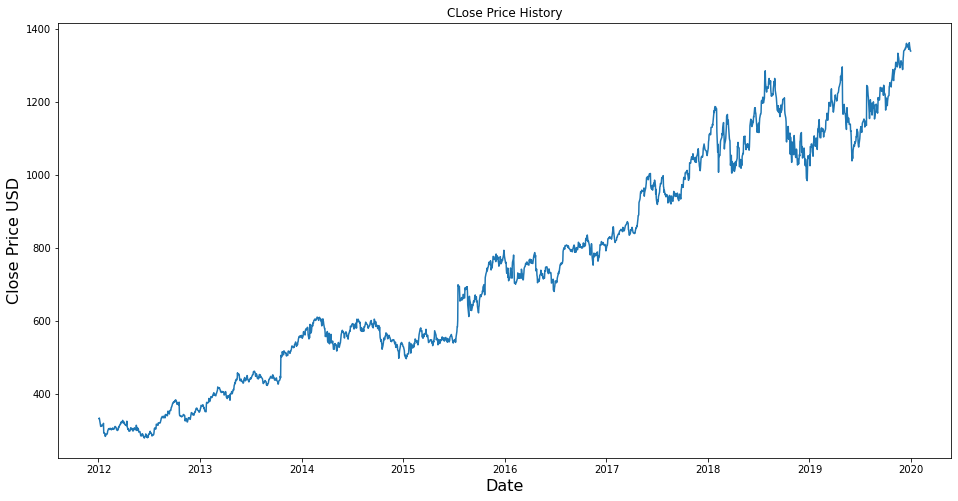

1550/1550 [==============================] - 45s 27ms/step - loss: 0.0022
ERROR rmse =  16.691579638428948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


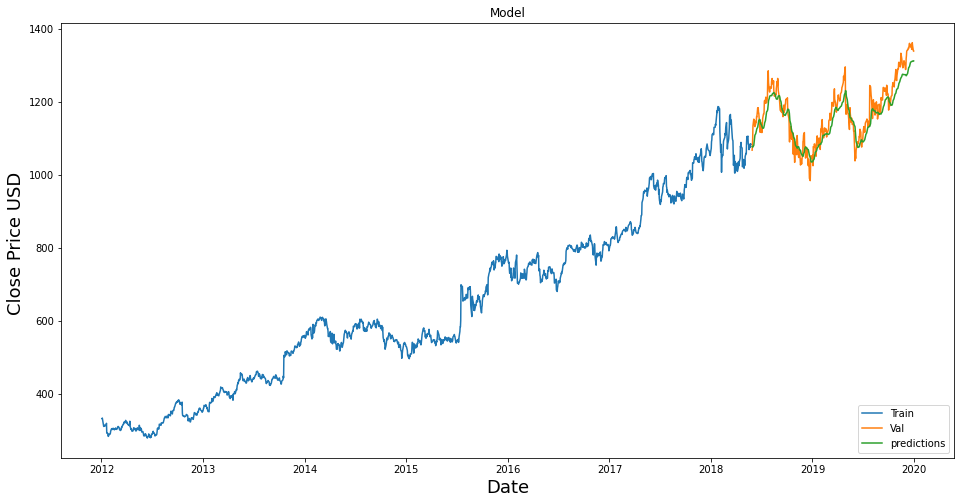

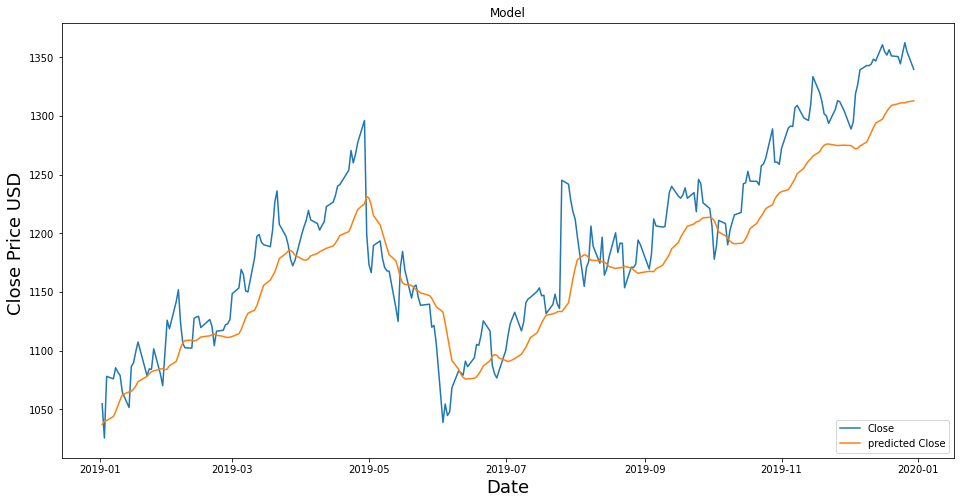

Starting Portfolio Value: 100000.00
2019-01-02, Close, 1054.68
2019-01-02, BUY CREATE, 1054.68
2019-01-03, BUY EXECUTED, Price: 1039.65, Cost: 10396.51, Comm 0.00
2019-01-03, Close, 1025.47
2019-01-03, BUY CREATE, 1025.47
2019-01-04, BUY EXECUTED, Price: 1040.45, Cost: 10404.52, Comm 0.00
2019-01-04, Close, 1078.07
2019-01-04, BUY CREATE, 1078.07
2019-01-07, BUY EXECUTED, Price: 1043.81, Cost: 10438.09, Comm 0.00
2019-01-07, Close, 1075.92
2019-01-07, BUY CREATE, 1075.92
2019-01-08, BUY EXECUTED, Price: 1047.86, Cost: 10478.64, Comm 0.00
2019-01-08, Close, 1085.37
2019-01-08, BUY CREATE, 1085.37
2019-01-09, BUY EXECUTED, Price: 1052.88, Cost: 10528.76, Comm 0.00
2019-01-09, Close, 1081.65
2019-01-09, BUY CREATE, 1081.65
2019-01-10, BUY EXECUTED, Price: 1057.95, Cost: 10579.51, Comm 0.00
2019-01-10, Close, 1078.83
2019-01-10, BUY CREATE, 1078.83
2019-01-11, BUY EXECUTED, Price: 1062.32, Cost: 10623.17, Comm 0.00
2019-01-11, Close, 1064.47
2019-01-11, BUY CREATE, 1064.47
2019-01-14, BUY 

In [ ]:
stockName = 'GOOGL'
google = trainingTheModel(path, stockName)
google.plotCloseVsDate()
google.splittingData()
google.modelArchitecture()
google.testModel()
google.visualizeTheTest()
predicted_df = google.simulateFuture60Days()
google.visualizeTestVsActual()
portofolio(google.df_predicted)

Final Portfolio Value: 126021.73

## Facebook (FB)

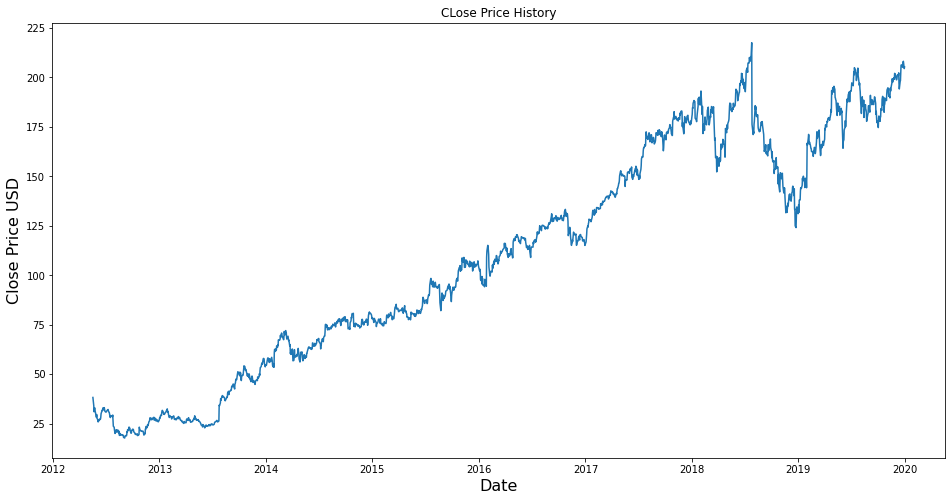

1474/1474 [==============================] - 44s 28ms/step - loss: 0.0024
ERROR rmse =  0.6247378914536758


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


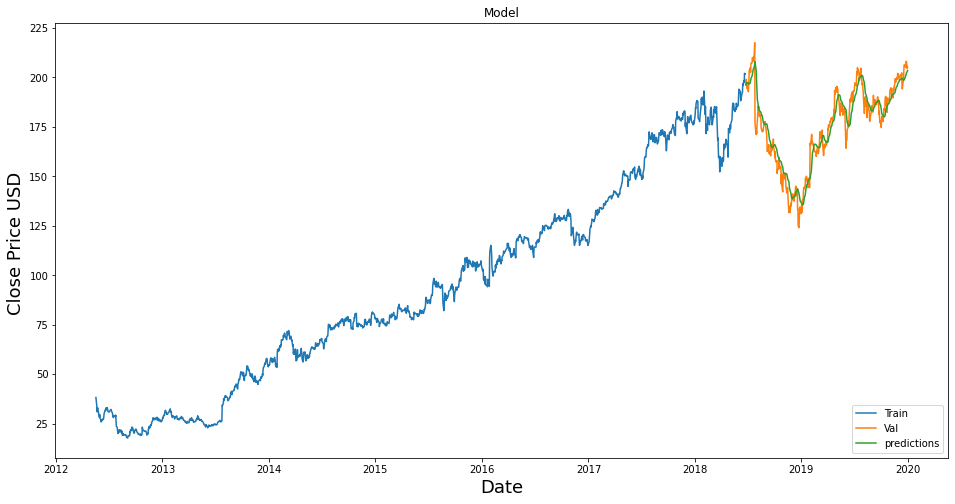

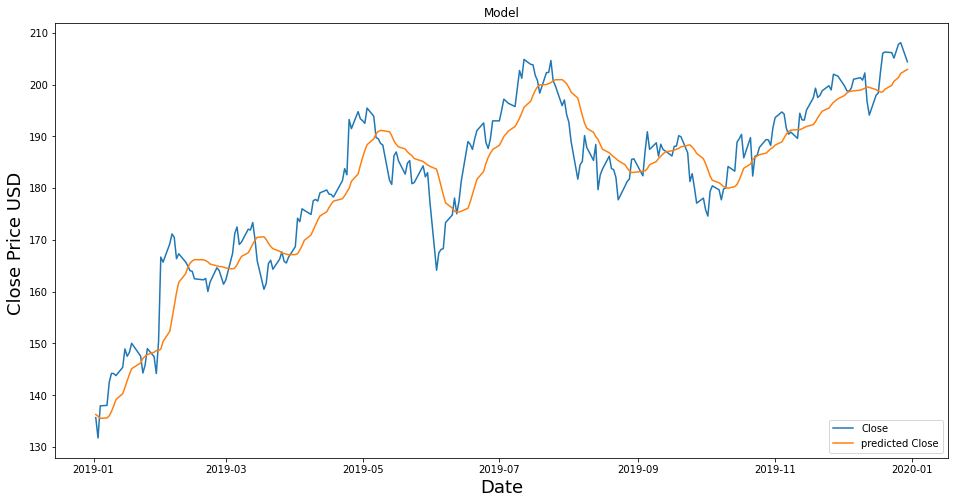

Starting Portfolio Value: 100000.00
2019-01-02, Close, 135.68
2019-01-02, BUY CREATE, 135.68
2019-01-03, BUY EXECUTED, Price: 135.96, Cost: 1359.59, Comm 0.00
2019-01-03, Close, 131.74
2019-01-03, SELL CREATE, 131.74
2019-01-04, SELL EXECUTED, Price: 135.54, Cost: 1359.59, Comm 0.00
2019-01-04, OPERATION PROFIT, GROSS -4.22, NET -4.22
2019-01-04, Close, 137.95
2019-01-04, BUY CREATE, 137.95
2019-01-07, BUY EXECUTED, Price: 135.62, Cost: 1356.22, Comm 0.00
2019-01-07, Close, 138.05
2019-01-07, BUY CREATE, 138.05
2019-01-08, BUY EXECUTED, Price: 136.02, Cost: 1360.24, Comm 0.00
2019-01-08, Close, 142.53
2019-01-08, BUY CREATE, 142.53
2019-01-09, BUY EXECUTED, Price: 136.87, Cost: 1368.70, Comm 0.00
2019-01-09, Close, 144.23
2019-01-09, BUY CREATE, 144.23
2019-01-10, BUY EXECUTED, Price: 137.97, Cost: 1379.71, Comm 0.00
2019-01-10, Close, 144.20
2019-01-10, BUY CREATE, 144.20
2019-01-11, BUY EXECUTED, Price: 139.16, Cost: 1391.60, Comm 0.00
2019-01-11, Close, 143.80
2019-01-11, BUY CREATE

In [ ]:
stockName = 'FB'
facebook = trainingTheModel(path, stockName)
facebook.plotCloseVsDate()
facebook.splittingData()
facebook.modelArchitecture()
facebook.testModel()
facebook.visualizeTheTest()
predicted_df = facebook.simulateFuture60Days()
facebook.visualizeTestVsActual()
portofolio(facebook.df_predicted)

Final Portfolio Value: 125435.79

## Amazon (AMZN)

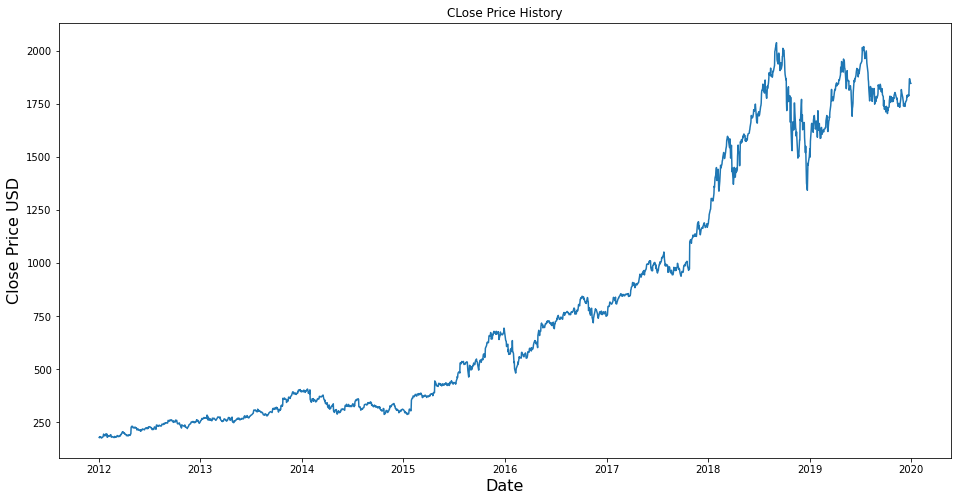

1550/1550 [==============================] - 46s 28ms/step - loss: 0.0013
ERROR rmse =  38.6590724964047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


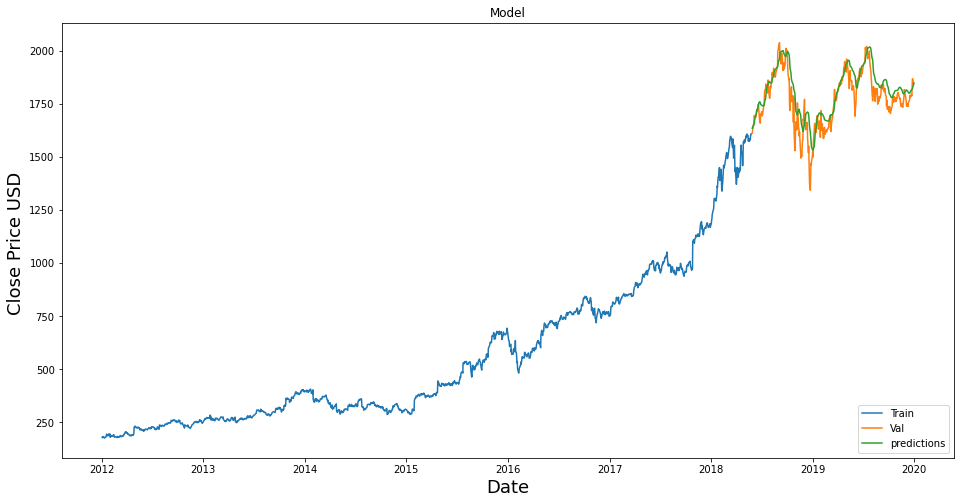

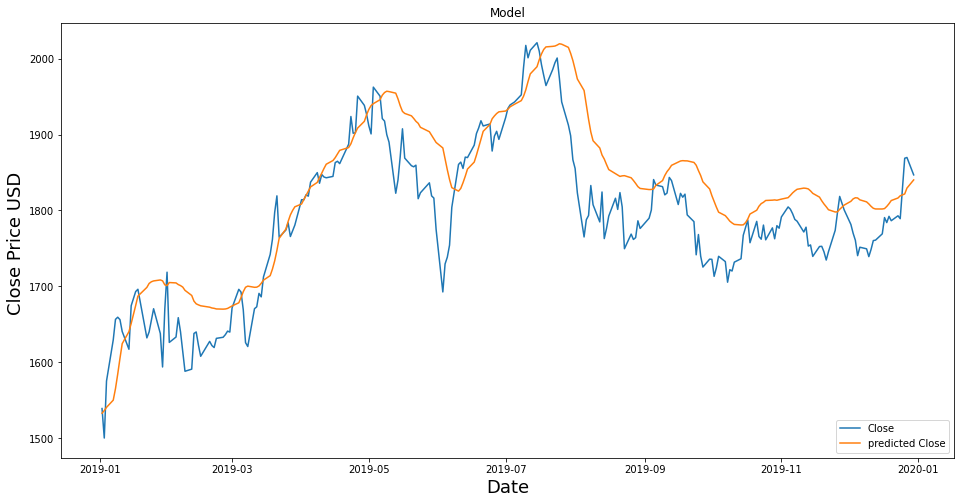

Starting Portfolio Value: 100000.00
2019-01-02, Close, 1539.13
2019-01-02, BUY CREATE, 1539.13
2019-01-03, BUY EXECUTED, Price: 1536.42, Cost: 15364.24, Comm 0.00
2019-01-03, Close, 1500.28
2019-01-03, SELL CREATE, 1500.28
2019-01-04, SELL EXECUTED, Price: 1540.70, Cost: 15364.24, Comm 0.00
2019-01-04, OPERATION PROFIT, GROSS 42.73, NET 42.73
2019-01-04, Close, 1575.39
2019-01-04, BUY CREATE, 1575.39
2019-01-07, BUY EXECUTED, Price: 1550.18, Cost: 15501.79, Comm 0.00
2019-01-07, Close, 1629.51
2019-01-07, BUY CREATE, 1629.51
2019-01-08, BUY EXECUTED, Price: 1565.36, Cost: 15653.59, Comm 0.00
2019-01-08, Close, 1656.58
2019-01-08, BUY CREATE, 1656.58
2019-01-09, BUY EXECUTED, Price: 1584.56, Cost: 15845.64, Comm 0.00
2019-01-09, Close, 1659.42
2019-01-09, BUY CREATE, 1659.42
2019-01-10, BUY EXECUTED, Price: 1605.21, Cost: 16052.05, Comm 0.00
2019-01-10, Close, 1656.22
2019-01-10, BUY CREATE, 1656.22
2019-01-11, BUY EXECUTED, Price: 1624.60, Cost: 16245.99, Comm 0.00
2019-01-11, Close, 1

In [ ]:
stockName = 'AMZN'
amazon = trainingTheModel(path, stockName)
amazon.plotCloseVsDate()
amazon.splittingData()
amazon.modelArchitecture()
amazon.testModel()
amazon.visualizeTheTest()
predicted_df = amazon.simulateFuture60Days()
amazon.visualizeTestVsActual()
portofolio(amazon.df_predicted)

Final Portfolio Value: 110831.76

## Apple (AAPL)

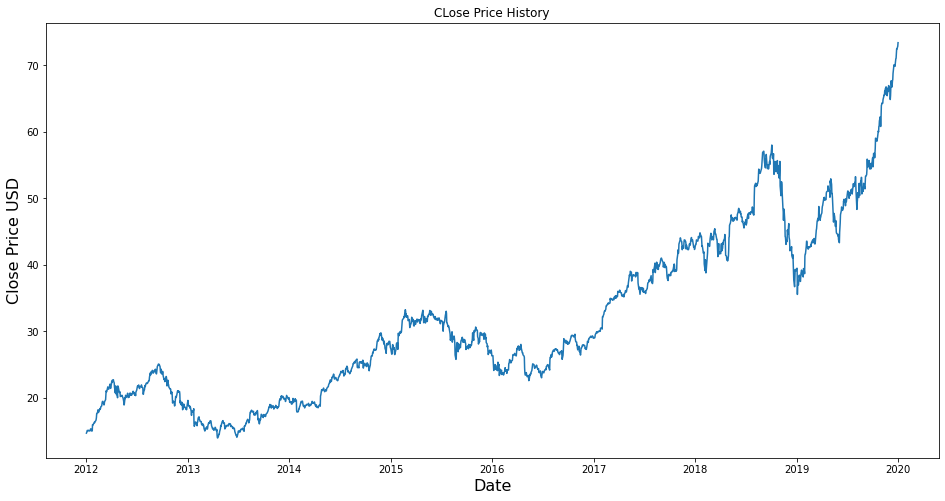

1550/1550 [==============================] - 45s 27ms/step - loss: 8.7898e-04
ERROR rmse =  5.669667685209816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


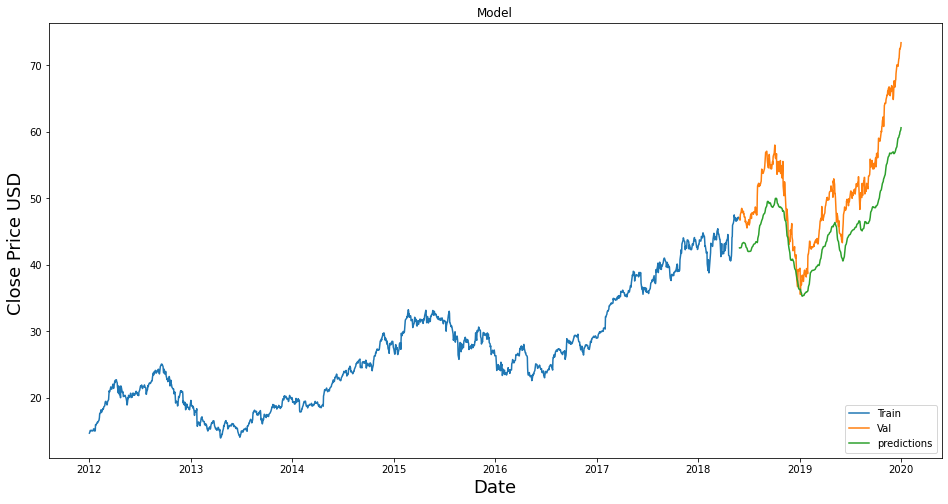

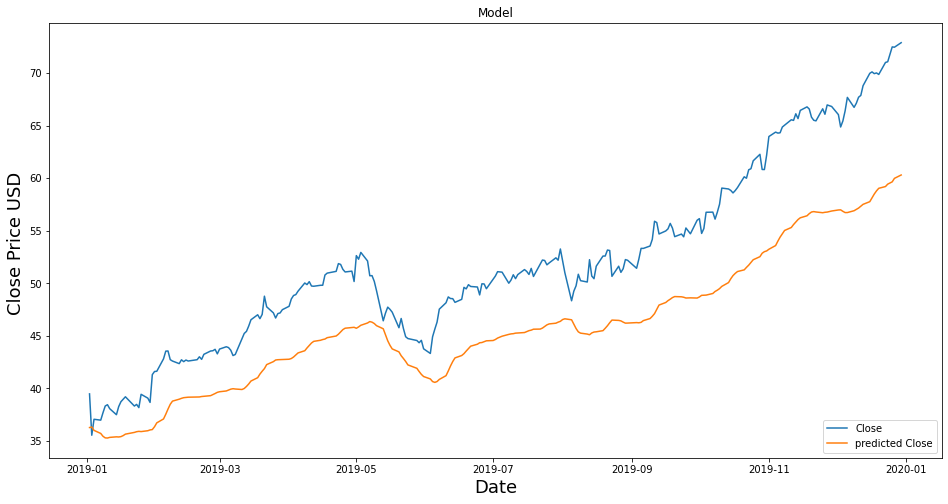

Starting Portfolio Value: 100000.00
2019-01-02, Close, 39.48
2019-01-02, BUY CREATE, 39.48
2019-01-03, BUY EXECUTED, Price: 36.33, Cost: 363.29, Comm 0.00
2019-01-03, Close, 35.55
2019-01-03, BUY CREATE, 35.55
2019-01-04, BUY EXECUTED, Price: 36.01, Cost: 360.10, Comm 0.00
2019-01-04, Close, 37.06
2019-01-04, BUY CREATE, 37.06
2019-01-07, BUY EXECUTED, Price: 35.72, Cost: 357.17, Comm 0.00
2019-01-07, Close, 36.98
2019-01-07, BUY CREATE, 36.98
2019-01-08, BUY EXECUTED, Price: 35.45, Cost: 354.49, Comm 0.00
2019-01-08, Close, 37.69
2019-01-08, BUY CREATE, 37.69
2019-01-09, BUY EXECUTED, Price: 35.30, Cost: 352.96, Comm 0.00
2019-01-09, Close, 38.33
2019-01-09, BUY CREATE, 38.33
2019-01-10, BUY EXECUTED, Price: 35.28, Cost: 352.82, Comm 0.00
2019-01-10, Close, 38.45
2019-01-10, BUY CREATE, 38.45
2019-01-11, BUY EXECUTED, Price: 35.34, Cost: 353.44, Comm 0.00
2019-01-11, Close, 38.07
2019-01-11, BUY CREATE, 38.07
2019-01-14, BUY EXECUTED, Price: 35.40, Cost: 353.96, Comm 0.00
2019-01-14, 

In [ ]:
stockName = 'AAPL'
apple = trainingTheModel(path, stockName)
apple.plotCloseVsDate()
apple.splittingData()
apple.modelArchitecture()
apple.testModel()
apple.visualizeTheTest()
predicted_df = apple.simulateFuture60Days()
apple.visualizeTestVsActual()
portofolio(apple.df_predicted)

Final Portfolio Value: 163476.31, meaning that it was the stock that gave us highest profits.

## Netflix (NFLX)

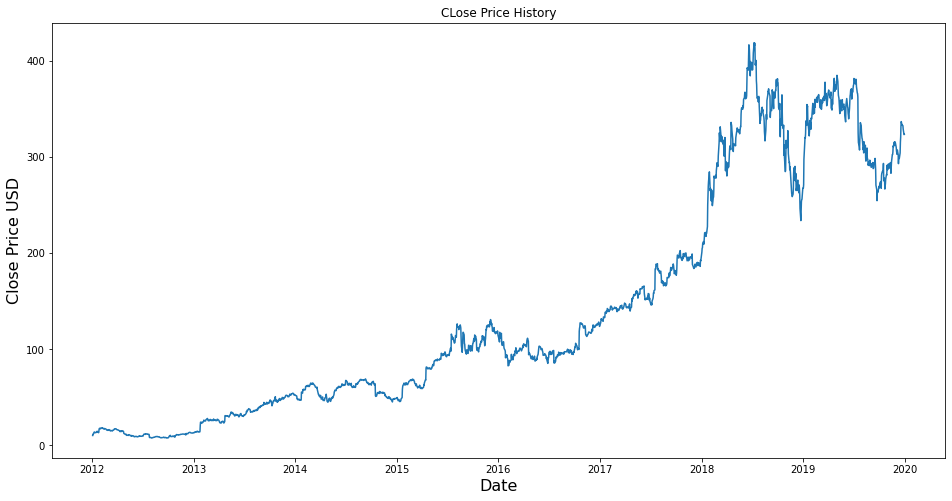

1550/1550 [==============================] - 46s 28ms/step - loss: 0.0016
ERROR rmse =  1.0160847374455846


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


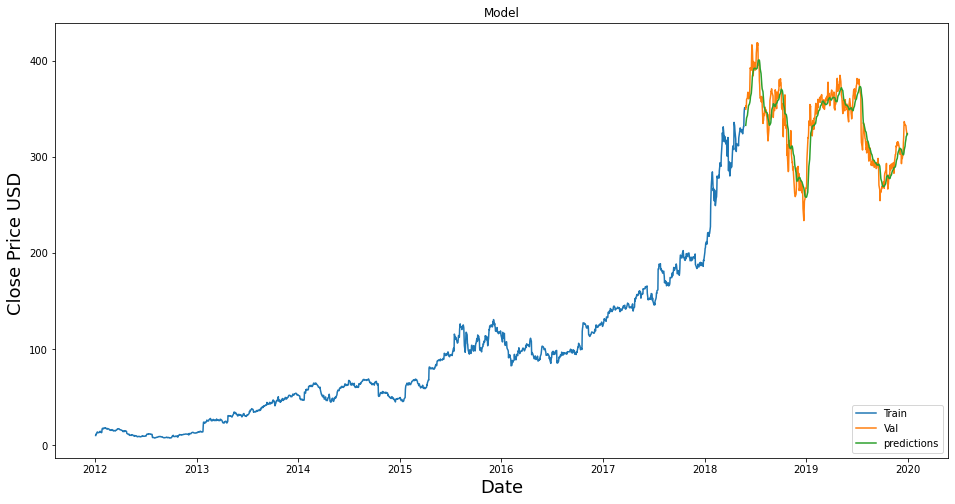

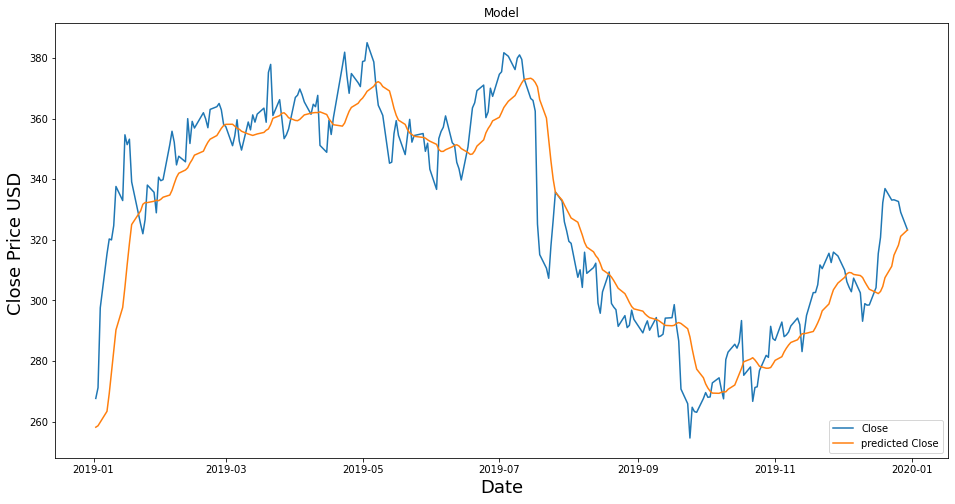

Starting Portfolio Value: 100000.00
2019-01-02, Close, 267.66
2019-01-02, BUY CREATE, 267.66
2019-01-03, BUY EXECUTED, Price: 258.64, Cost: 2586.42, Comm 0.00
2019-01-03, Close, 271.20
2019-01-03, BUY CREATE, 271.20
2019-01-04, BUY EXECUTED, Price: 259.82, Cost: 2598.23, Comm 0.00
2019-01-04, Close, 297.57
2019-01-04, BUY CREATE, 297.57
2019-01-07, BUY EXECUTED, Price: 263.41, Cost: 2634.07, Comm 0.00
2019-01-07, Close, 315.34
2019-01-07, BUY CREATE, 315.34
2019-01-08, BUY EXECUTED, Price: 269.27, Cost: 2692.70, Comm 0.00
2019-01-08, Close, 320.27
2019-01-08, BUY CREATE, 320.27
2019-01-09, BUY EXECUTED, Price: 276.25, Cost: 2762.52, Comm 0.00
2019-01-09, Close, 319.96
2019-01-09, BUY CREATE, 319.96
2019-01-10, BUY EXECUTED, Price: 283.28, Cost: 2832.83, Comm 0.00
2019-01-10, Close, 324.66
2019-01-10, BUY CREATE, 324.66
2019-01-11, BUY EXECUTED, Price: 290.27, Cost: 2902.66, Comm 0.00
2019-01-11, Close, 337.59
2019-01-11, BUY CREATE, 337.59
2019-01-14, BUY EXECUTED, Price: 297.67, Cost:

In [ ]:
stockName = 'NFLX'
netflix = trainingTheModel(path, stockName)
netflix.plotCloseVsDate()
netflix.splittingData()
netflix.modelArchitecture()
netflix.testModel()
netflix.visualizeTheTest()
predicted_df = netflix.simulateFuture60Days()
netflix.visualizeTestVsActual()
portofolio(netflix.df_predicted)

Final Portfolio Value: 101742.85

# Future Work: 
We enjoyed working on this experiment, but unfortunately the steps we took to reach this point were timely, and we had to move on to other tasks. However if we had the time, we could have done the following:
- Modifying the model somehow to be trained online. 
- Using different advanced trading algorithms, while implementing an incluive portfolio managing all the stocks to maximize the final profit. (More realistic domain approach) 
- Using Berts instead of Glove to take context dependence into consideration
- Comparing it to S&P 500, although these numbers might look like exceeding it.
- Running the LSTM model with and without the sentiment data, and compare between both times.
- Having a closer look to stock prices changes, and link them with actual news concerning the company.

# References: 
- We scraped the Data to train the our sentiment analysis model. Then, we used the dataset from this link https://unisydneyedu-my.sharepoint.com/personal/mjag7682_uni_sydney_edu_au/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fmjag7682%5Funi%5Fsydney%5Fedu%5Fau%2FDocuments%2FUni%5FStudy%5FMaterial%2Fdataset%2FLabelled%20Datatset%2D002%2Ezip&parent=%2Fpersonal%2Fmjag7682%5Funi%5Fsydney%5Fedu%5Fau%2FDocuments%2FUni%5FStudy%5FMaterial%2Fdataset&ga=1
for predicting the tomorrow's close price.
- We implemented the LSTM model on our own, but we took inspirations from the link below. 
  - https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/
- It was our Greedy algorithm idea.
However, we took some references as a general guideline: 

  
  - https://github.com/mjag7682/NLP-of-StockTwits-data-for-predicting-stocks
  - Link of the website we scraped from 
    - https://stocktwits.com/   (tweets)
    - https://finance.yahoo.com/ (close price)


